tar: spark-3.5.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# Cài Java (bắt buộc cho Spark)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null


In [ ]:
# Tải Spark từ Apache Mirror (link mới ổn định)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz


In [ ]:
# Cài findspark và pyspark
!pip install -q findspark pyspark


In [ ]:
import requests
import pandas as pd
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import os
import findspark
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime

Mounted at /content/drive


In [1]:
# Cài đặt Java & Spark
!apt-get install openjdk-11-jdk -qq
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Cài đặt PySpark
!pip install -q pyspark

# Thiết lập biến môi trường
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"


Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../0-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fonts-dejavu-extra.
Preparing to unpack .../1-fonts-dejavu-extra_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-extra (2.37-2build1) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../2-libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package libxxf86dga1:amd64.
Preparing to unpack .../3-libxxf86dga1_2%3a1.1.5-0ubuntu3_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.5-0ubuntu3) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../4-x11-utils_7.7+5build2_amd64.deb ...
Unpacking x11-utils (7.7+5build2) ...
Selecting previously unselected package libatk-wrapper-java.
Preparin

In [2]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
os.environ["PATH"] += ":/content/spark-3.5.0-bin-hadoop3/bin:/content/spark-3.5.0-bin-hadoop3/sbin"


In [ ]:
# Khởi tạo môi trường findspark

findspark.init("/content/spark-3.5.1-bin-hadoop3")



spark = SparkSession.builder.appName("WeatherClustering").getOrCreate()
spark


In [ ]:


API_KEY = "a1ea06a445dbedc43c743ad68f121ead"  # 🔹 Thay bằng API key của bạn
cities = ["Hanoi", "Ho Chi Minh", "Da Nang", "Hai Phong", "Can Tho", "Nha Trang", "Hue", "Vinh", "Da Lat", "Quy Nhon"]

data_list = []

for city in cities:
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city},VN&appid={API_KEY}&units=metric"
    response = requests.get(url).json()

    if response.get("cod") != 200:
        print(f" Lỗi khi lấy dữ liệu {city}: {response.get('message')}")
        continue

    data_list.append({
        "city": city,
        "temp": response["main"]["temp"],
        "feels_like": response["main"]["feels_like"],
        "humidity": response["main"]["humidity"],
        "pressure": response["main"]["pressure"],
        "wind_speed": response["wind"]["speed"]
    })

    time.sleep(1)  # tránh bị giới hạn request

data = pd.DataFrame(data_list)
print(data)


 Lỗi khi lấy dữ liệu Hai Phong: city not found
          city   temp  feels_like  humidity  pressure  wind_speed
0        Hanoi  27.83       32.89        88      1003        3.03
1  Ho Chi Minh  30.47       37.47        84      1008        3.70
2      Da Nang  31.29       38.29        73      1005        3.23
3      Can Tho  28.73       35.73        93      1008        3.85
4    Nha Trang  29.65       35.85        77      1008        2.21
5          Hue  32.25       39.25        70      1004        0.93
6         Vinh  30.15       34.44        66      1003        2.84
7       Da Lat  18.34       18.66        93      1013        0.78
8     Quy Nhon  28.53       32.74        76      1007        4.51


In [ ]:
df_spark = spark.createDataFrame(data)
df_spark.show()


+-----------+-----+----------+--------+--------+----------+
|       city| temp|feels_like|humidity|pressure|wind_speed|
+-----------+-----+----------+--------+--------+----------+
|      Hanoi|27.83|     32.89|      88|    1003|      3.03|
|Ho Chi Minh|30.47|     37.47|      84|    1008|       3.7|
|    Da Nang|31.29|     38.29|      73|    1005|      3.23|
|    Can Tho|28.73|     35.73|      93|    1008|      3.85|
|  Nha Trang|29.65|     35.85|      77|    1008|      2.21|
|        Hue|32.25|     39.25|      70|    1004|      0.93|
|       Vinh|30.15|     34.44|      66|    1003|      2.84|
|     Da Lat|18.34|     18.66|      93|    1013|      0.78|
|   Quy Nhon|28.53|     32.74|      76|    1007|      4.51|
+-----------+-----+----------+--------+--------+----------+



In [ ]:


# Chọn cột đặc trưng
feature_cols = ["temp", "feels_like", "humidity", "pressure", "wind_speed"]

# Chuyển thành vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_spark)

# KMeans
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_features)

# Dự đoán cụm
predictions = model.transform(df_features)
predictions.select("city", "features", "prediction").show()

# Tâm cụm
centers = model.clusterCenters()
print("Tâm các cụm:")
for i, center in enumerate(centers):
    print(f"Cụm {i}: {center}")


+-----------+--------------------+----------+
|       city|            features|prediction|
+-----------+--------------------+----------+
|      Hanoi|[27.83,32.89,88.0...|         1|
|Ho Chi Minh|[30.47,37.47,84.0...|         1|
|    Da Nang|[31.29,38.29,73.0...|         0|
|    Can Tho|[28.73,35.73,93.0...|         1|
|  Nha Trang|[29.65,35.85,77.0...|         0|
|        Hue|[32.25,39.25,70.0...|         0|
|       Vinh|[30.15,34.44,66.0...|         0|
|     Da Lat|[18.34,18.66,93.0...|         2|
|   Quy Nhon|[28.53,32.74,76.0...|         0|
+-----------+--------------------+----------+

Tâm các cụm:
Cụm 0: [  30.374   36.114   72.4   1005.4      2.744]
Cụm 1: [  29.01         35.36333333   88.33333333 1006.33333333    3.52666667]
Cụm 2: [1.834e+01 1.866e+01 9.300e+01 1.013e+03 7.800e-01]


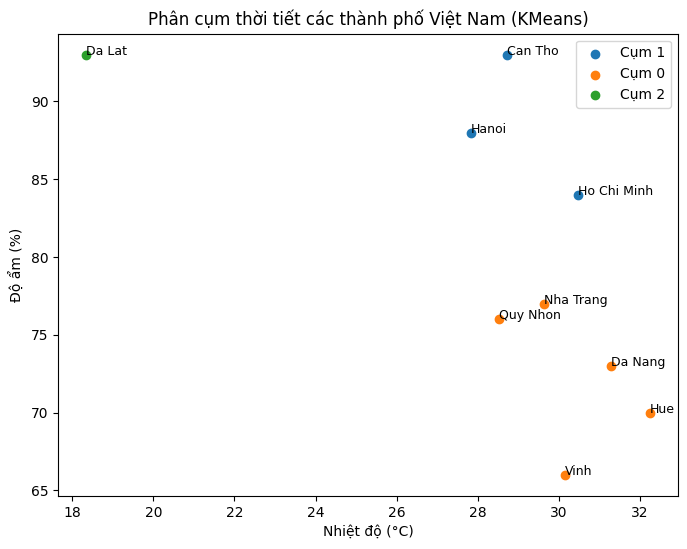

In [ ]:


# Chuyển Spark DataFrame -> Pandas để vẽ
pdf = predictions.select("city", "temp", "humidity", "prediction").toPandas()

plt.figure(figsize=(8,6))
for cluster in pdf["prediction"].unique():
    cluster_data = pdf[pdf["prediction"] == cluster]
    plt.scatter(cluster_data["temp"], cluster_data["humidity"], label=f"Cụm {cluster}")

# Ghi tên thành phố lên biểu đồ
for i, row in pdf.iterrows():
    plt.text(row["temp"], row["humidity"], row["city"], fontsize=9)

plt.xlabel("Nhiệt độ (°C)")
plt.ylabel("Độ ẩm (%)")
plt.legend()
plt.title("Phân cụm thời tiết các thành phố Việt Nam (KMeans)")
plt.show()


In [ ]:


output_path = "/content/drive/MyDrive/BigData project/weather_clusters.csv"
pdf.to_csv(output_path, index=False)
print(f" Đã lưu file tại: {output_path}")


 Đã lưu file tại: /content/drive/MyDrive/BigData project/weather_clusters.csv


Dự báo 5 ngày / 3 giờ


In [ ]:


data_list_5d = []

for city in cities:
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={city},VN&appid={API_KEY}&units=metric"
    res = requests.get(url).json()
    if res.get("cod") != "200":
        print(f"Lỗi khi lấy {city}: {res.get('message')}")
        continue
    for item in res["list"]:
        data_list_5d.append({
            "city": city,
            "date": datetime.fromtimestamp(item["dt"]).date(),
            "time": datetime.fromtimestamp(item["dt"]).time(),
            "temp": item["main"]["temp"],
            "feels_like": item["main"]["feels_like"],
            "humidity": item["main"]["humidity"],
            "pressure": item["main"]["pressure"],
            "wind_speed": item["wind"]["speed"]
        })
    time.sleep(1)

data_5d = pd.DataFrame(data_list_5d)


Lỗi khi lấy Hai Phong: city not found


 Phân cụm riêng từng ngày

In [ ]:
unique_dates = sorted(data_5d["date"].unique())

for day in unique_dates:
    print(f"\n📅 Phân cụm cho ngày {day}")

    # Lọc dữ liệu của 1 ngày
    day_data = data_5d[data_5d["date"] == day].copy()

    # Chuyển date và time sang string để Spark không lỗi
    day_data["date"] = day_data["date"].astype(str)
    day_data["time"] = day_data["time"].astype(str)

    # Tạo Spark DataFrame
    df_spark_day = spark.createDataFrame(day_data)

    # Vector hóa
    assembler = VectorAssembler(
        inputCols=["temp", "feels_like", "humidity", "pressure", "wind_speed"],
        outputCol="features"
    )
    df_features_day = assembler.transform(df_spark_day)

    # KMeans
    kmeans = KMeans(k=3, seed=42)
    model = kmeans.fit(df_features_day)
    predictions = model.transform(df_features_day)

    # Hiển thị kết quả
    predictions.select("city", "time", "prediction").show(10)



📅 Phân cụm cho ngày 2025-08-05
+-----------+--------+----------+
|       city|    time|prediction|
+-----------+--------+----------+
|      Hanoi|15:00:00|         2|
|      Hanoi|18:00:00|         2|
|      Hanoi|21:00:00|         2|
|Ho Chi Minh|15:00:00|         2|
|Ho Chi Minh|18:00:00|         2|
|Ho Chi Minh|21:00:00|         2|
|    Da Nang|15:00:00|         0|
|    Da Nang|18:00:00|         0|
|    Da Nang|21:00:00|         0|
|    Can Tho|15:00:00|         2|
+-----------+--------+----------+
only showing top 10 rows


📅 Phân cụm cho ngày 2025-08-06
+-----------+--------+----------+
|       city|    time|prediction|
+-----------+--------+----------+
|      Hanoi|00:00:00|         1|
|      Hanoi|03:00:00|         0|
|      Hanoi|06:00:00|         0|
|      Hanoi|09:00:00|         0|
|      Hanoi|12:00:00|         1|
|      Hanoi|15:00:00|         1|
|      Hanoi|18:00:00|         1|
|      Hanoi|21:00:00|         1|
|Ho Chi Minh|00:00:00|         0|
|Ho Chi Minh|03:00:00|    

In [ ]:
timeline_results = []  # Lưu kết quả để vẽ biểu đồ

unique_dates = sorted(data_5d["date"].unique())

for day in unique_dates:
    print("="*50)
    print(f"📅 Phân cụm cho ngày {day}")
    print("="*50)

    # Lọc dữ liệu cho ngày này
    day_data = data_5d[data_5d["date"] == day].copy()
    day_data["date"] = day_data["date"].astype(str)
    day_data["time"] = day_data["time"].astype(str)

    # Tạo Spark DataFrame
    df_spark_day = spark.createDataFrame(day_data)

    # Vector hóa
    assembler = VectorAssembler(
        inputCols=["temp", "feels_like", "humidity", "pressure", "wind_speed"],
        outputCol="features"
    )
    df_features_day = assembler.transform(df_spark_day)

    # KMeans
    kmeans = KMeans(k=3, seed=42)
    model = kmeans.fit(df_features_day)
    predictions = model.transform(df_features_day).toPandas()

    # Hiển thị bảng kết quả chi tiết
    predictions_sorted = predictions.sort_values(by=["time", "city"])
    print(predictions_sorted[["time", "city", "temp", "humidity", "pressure", "wind_speed", "prediction"]])

    # Lưu dữ liệu để vẽ heatmap/timeline
    for _, row in predictions_sorted.iterrows():
        timeline_results.append({
            "city": row["city"],
            "date": row["date"],
            "prediction": row["prediction"]
        })

# Chuyển sang DataFrame Pandas
timeline_df = pd.DataFrame(timeline_results)


📅 Phân cụm cho ngày 2025-08-05
        time         city   temp  humidity  pressure  wind_speed  prediction
9   15:00:00      Can Tho  29.04        89      1008        3.32           2
21  15:00:00       Da Lat  18.52        94      1013        0.45           1
6   15:00:00      Da Nang  31.12        75      1005        1.83           0
0   15:00:00        Hanoi  28.71        86      1003        3.93           2
3   15:00:00  Ho Chi Minh  31.27        82      1008        3.39           2
15  15:00:00          Hue  31.65        72      1005        1.40           0
12  15:00:00    Nha Trang  29.94        79      1008        2.39           0
24  15:00:00     Quy Nhon  28.42        78      1006        2.56           0
18  15:00:00         Vinh  30.01        68      1002        2.64           0
10  18:00:00      Can Tho  27.51        91      1008        2.75           2
22  18:00:00       Da Lat  18.01        97      1013        0.79           1
7   18:00:00      Da Nang  29.57        75   

<Figure size 1000x600 with 0 Axes>

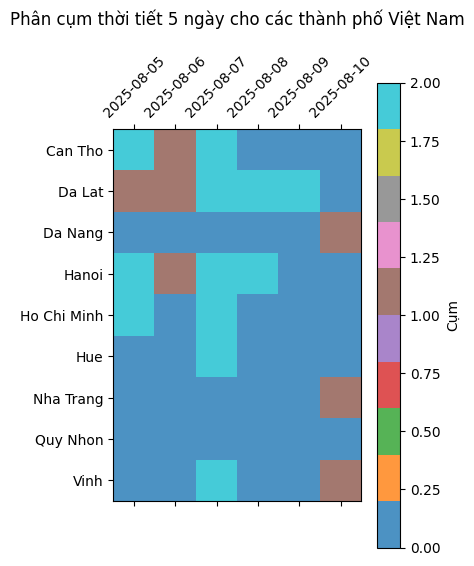

In [ ]:
# Pivot để vẽ heatmap (city là hàng, date là cột, prediction là giá trị)
pivot_df = timeline_df.pivot_table(index="city", columns="date", values="prediction", aggfunc="first")

# Vẽ heatmap
plt.figure(figsize=(10, 6))
cax = plt.matshow(pivot_df, cmap="tab10", alpha=0.8)
plt.colorbar(cax, label="Cụm")

# Gán tên trục
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=45)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)

plt.title("Phân cụm thời tiết 5 ngày cho các thành phố Việt Nam", pad=20)
plt.show()

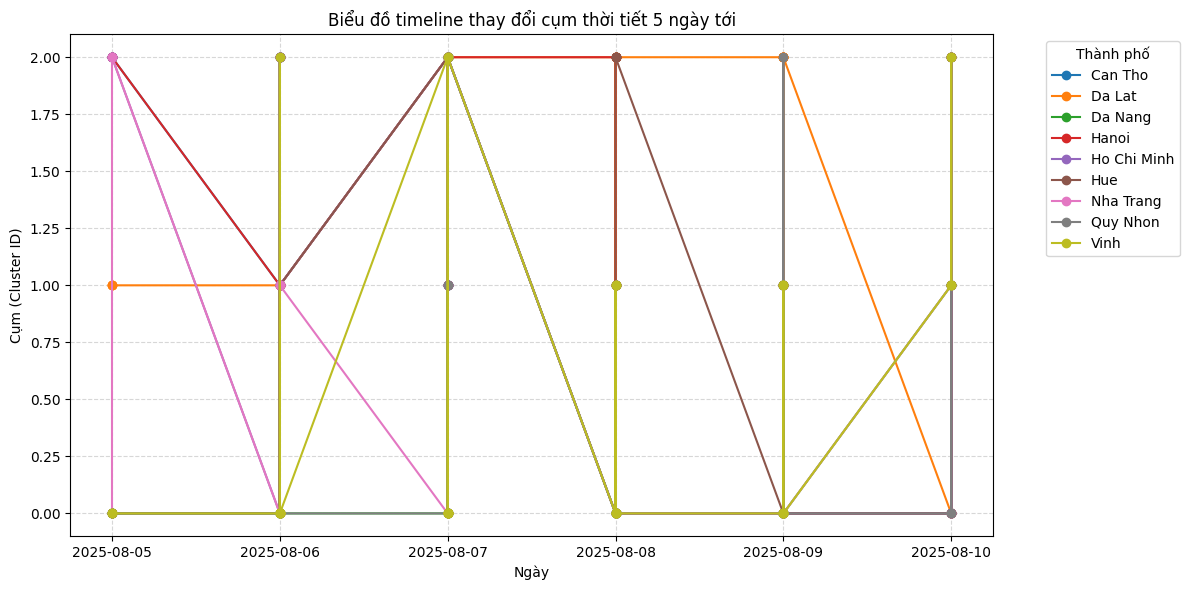

In [ ]:


# Tạo DataFrame kết quả từ phần phân cụm 5 ngày trước đó
timeline_df = pd.DataFrame(timeline_results)

# Sắp xếp dữ liệu theo ngày
timeline_df = timeline_df.sort_values(by=["city", "date"])

# Vẽ biểu đồ timeline dạng đường
plt.figure(figsize=(12, 6))

for city in timeline_df["city"].unique():
    city_data = timeline_df[timeline_df["city"] == city]
    plt.plot(city_data["date"], city_data["prediction"], marker="o", label=city)

plt.xlabel("Ngày")
plt.ylabel("Cụm (Cluster ID)")
plt.title("Biểu đồ timeline thay đổi cụm thời tiết 5 ngày tới")
plt.legend(title="Thành phố", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
